# Tagging genes with ddlite: learning and labeling function iteration

## Introduction
In this example **ddlite** app, we'll build a gene tagger from scratch. Domain-specific tagging systems take months or years to develop. They use hand-crafted model circuitry and accurate, hand-labeled training data. We'll start to build a pretty good one in a few minutes with none of those things. The generalized extraction and learning utilities provided by ddlite will allow us to turn a sampling of article abstracts and some basic domain knowledge into an automated tagging system. Specifically, we want an accurate tagger for genes in academic articles. We have comprehensive dictionaries of genes, but applying a simple matching rule might yield a lot of false positives. For example, "p53" might get tagged as a gene if it refers to a page number. Our goal is to use distant supervision to improve precision.

Here's the pipeline we'll follow:

1. Obtain and parse input data (relevant article abstracts from PubMed)
2. Extract candidates for tagging
3. Generate features
4. Create a test set
5. Write labeling functions
6. Learn the tagging model
7. Iterate on labeling functions

Parts 3 through 7 are covered in this notebook. It requires candidates extracted from `GeneTaggerExample_Extraction.ipynb`, which covers parts 1 and 2.

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import cPickle
import numpy as np
import matplotlib
# print(os.environ['SNORKELDB'])
# Use production DB
from set_env import set_env
set_env() 
sys.path.insert(1, '../snorkel')

# Must set SNORKELDB before importing SnorkelSession
from snorkel import SnorkelSession
from snorkel.parser import TextDocPreprocessor
from snorkel.parser import CorpusParser
from snorkel.models import Document, Sentence, candidate_subclass
from snorkel.viewer import SentenceNgramViewer
session = SnorkelSession()

#np.random.seed(seed=1701)

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,6)

Using postgres 1


## Loading candidate extractions
First, we'll load in the candidates that we created in the last notebook. We can construct an docs object with the file.

In [2]:
PhenoPair = candidate_subclass('ComplexPhenotypes', ['descriptor', 'entity'])

docs = session.query(PhenoPair).filter(PhenoPair.split == 3).all()  #should edit split to be 1. 

print "Documents:", session.query(Document).count()
print "Sentences:", session.query(Sentence).count()

##Once we get all the labels, for loop through all docs and split into train, dev, test. 

print 'Document set:\t{0} candidates'.format(len(docs))

Documents: 400
Sentences: 95656
Document set:	49042 candidates


In [3]:
from snorkel.models.context import TemporaryContext
import re

print docs

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## Make Labeling Functions

In [3]:
import re
import os
from snorkel.lf_helpers import (
    get_left_tokens,
    get_between_tokens,
    get_right_tokens,
    contains_token,
    get_text_between,
    get_text_splits,
    get_tagged_text,
    is_inverted,
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
    
)


def LF_mutant(c):
    return 1 if ('mutant' in get_right_tokens(c, attrib='lemmas')) or ('mutant' in get_left_tokens(c, attrib='lemmas')) else 0
def LF_variant(c):
    return 1 if ('variant' in get_right_tokens(c, attrib='lemmas')) or ('variant' in get_left_tokens(c, attrib='lemmas')) else 0
def LF_express(c):
    return 1 if ('express' in get_right_tokens(c, attrib='lemmas')) or ('express' in get_left_tokens(c, attrib='lemmas')) else 0  
def LF_JJ(c):
    return 1 if 'JJ' in get_right_tokens(c, attrib='pos_tags') else 0
def LF_IN(c):
    return 1 if 'IN' in get_right_tokens(c, window=1, attrib='pos_tags') else 0
def LF_dna(c):
    return -1 if contains_token(c, 'DNA', attrib='words') else 0
def LF_rna(c):
    return -1 if contains_token(c, 'RNA', attrib='words') else 0
def LF_snp(c):
    return -1 if contains_token(c, 'SNP', attrib='words') else 0
def LF_protein(c):
    return -1 if 'protein' in get_left_tokens(c, attrib='lemmas') else 0
def LF_LRB(c):
    return -1 if '-LRB-' in get_right_tokens(c, window=1, attrib='pos_tags') else 0
def LF_RRB(c):
    return -1 if '-RRB-' in get_right_tokens(c, window=1, attrib='pos_tags') else 0    
def LF_NNP(c):
    return -1 if contains_token(c, 'NNP', attrib='pos_tags') else 0
def lfdistBtw0(c):
    return 1 if len(get_between_tokens(c, attrib="words")) == 0 else 0
def lfdistBtw(c):
    return 1 if len(get_between_tokens(c, attrib="words")) < 3 else 0
def lfdistBtwNeg(c):
    return -1 if len(get_between_tokens(c, attrib="words")) > 4 else 0
def lfdistBtwNeg2(c):
    return -1 if len(get_between_tokens(c, attrib="words")) > 8 else 0

action_link_words = set(['affect', 'lead', 'led', 'show', 'display', 'exhibit', 'cause', 'result in'])
mutant_words = set(['mutant', 'mutation', 'plant', 'line', 'phenotype', 'seedlings', 'variant'])
helper_vbs = set(['is', 'was', 'are', 'were', 'become', 'became'])
tester_words = set(['sequence', 'published', 'diagram', 'hypothesis', 'hypothesize', 'aim', 'goal', 'understand', 'examine', 'we', 'our', 'experiment', 'test', 'study', 'design', 'analyze', 'analysis', 'results', 'research'])
neg_words = set(['strategy', 'public', 'examine', 'measure', 'subject', 'statistic', 'instance'])

def lfnegWords(c):
    for word in neg_words:
        if contains_token(c, word, attrib='lemmas'): return -1
    return 0    

def resultsAlone(c):
    return -1 if (len(c[0].get_attrib_tokens('words')) == 1 and contains_token(c[0], 'result', attrib='lemmas')) or (len(c[1].get_attrib_tokens('lemmas')) == 1 and contains_token(c[1], 'result', attrib='lemmas')) else 0

def lfLenCand(c):
    return -1 if len(c[0].get_attrib_tokens('words')) == 1 or len(c[1].get_attrib_tokens('words')) == 1 else 0

def lf1(c):
    return 1 if 'in' in get_between_tokens(c, attrib='words') else 0

def lf2(c):
    return 1 if len(action_link_words.intersection(set(get_between_tokens(c, attrib='lemmas')))) > 0 else 0

def lf2a(c):
    for aw in action_link_words:
        if contains_token(c[1], aw, attrib='lemmas'): return 1
    return 0

def lf3(c):
    return 1 if contains_token(c[0], 'JJR', attrib='pos_tags') else 0

def lf4(c):
    return 1 if contains_token(c, r'fold') or contains_token(c, r'\d+(\.\d+_)?%') or contains_token(c, 'percent') else 0

def lf5(c):
    return 1 if len(mutant_words.intersection(set(get_left_tokens(c, attrib='lemmas')))) > 0 or len(mutant_words.intersection(set(get_right_tokens(c, attrib='lemmas')))) > 0 else 0

def lf6(c):
    return 1 if len(helper_vbs.intersection(set(get_between_tokens(c, attrib='lemmas', n_max=3)))) > 0 else 0

def lf7(c):
    return -1 if 'not' in get_between_tokens(c) else 0

def lf8(c):
    return -1 if 'not' in get_left_tokens(c[0]) or 'not' in get_left_tokens(c[1]) else 0

def lf9(c):
    return -1 if 'level' in get_left_tokens(c[0], attrib='lemmas', n_max=2) or 'level' in get_right_tokens(c[0], attrib='lemmas', n_max=2) else 0

def lf10(c):
    return -1 if 'transcript' in get_left_tokens(c[0], attrib='lemmas', n_max=3) or 'transcript' in get_right_tokens(c[0], attrib='lemmas', n_max=2) else 0

def lf11(c):
    return -1 if not contains_token(c, 'JJR', attrib='pos_tags') and not contains_token(c, 'JJ', attrib='pos_tags') and not contains_token(c[1], 'VBN', attrib='pos_tags') else 0

def inverted(c):
    return 1 if is_inverted(c) else 0

def lf12(c):
    return 1 if inverted(c) and lf1(c) else 0

def lf13(c):
    return 1 if inverted(c) and 'IN' in get_between_tokens(c, attrib='pos_tags', n_max=4) else 0

def lf14(c):
    return 1 if contains_token(c, 'phenotype', attrib='lemmas') else 0

def lf15(c):
    return -1 if 'protein' in get_left_tokens(c[0], attrib='lemmas') or 'protein' in get_right_tokens(c[0], attrib='lemmas') else 0

def lf16(c):
    return -1 if 'activity' in get_left_tokens(c[0], attrib='lemmas', n_max=2) or 'level' in get_right_tokens(c[0], attrib='lemmas', n_max=1) else 0

def lf17(c):
    return -1 if len(tester_words.intersection(set(get_tagged_text(c).split()))) > 0 else 0

# def LF_gene_dp(c):
#     return 1 if 'gene' in get_left_tokens(c[0], window=2, attrib='lemmas') else 0
# def LF_genotype_dp(c):
#     return 1 if 'genotype' in get_left_tokens(c[0], window=2, attrib='lemmas') else 0
def LF_phenotype_dp(c):
    return 1 if 'phenotype' in get_right_tokens(c[1], window=2, attrib='lemmas') else 0
def LF_mutation(c):
    return 1 if ('mutation' in get_right_tokens(c[0], window=2, attrib='lemmas') or 'mutant' in get_right_tokens(c[0], window=2, attrib='lemmas') or 'mutations' in get_right_tokens(c[0], window=2, attrib='lemmas')) else 0

def LF_pheno(c):
    return 1 if contains_token(c, 'phenotype', attrib='words') else 0

def LF_dev_dp(c):
    return -1 if 'development' in get_right_tokens(c[1], window=2, attrib='lemmas')  else 0
def LF_protein_dp(c):
    return -1 if 'protein' in get_left_tokens(c[1], window=2, attrib='lemmas') or 'protein' in get_right_tokens(c[1], window=2, attrib='lemmas') else 0
def LF_network_dp(c):
    return -1 if 'network' in get_right_tokens(c[1], window=2, attrib='lemmas') else 0
def LF_JJ_dp(c):
    return -1 if 'JJ' in get_right_tokens(c[1], window=2, attrib='pos_tags') else 0

def lf_helpers(c):
    return 1 if any(word in get_left_tokens(c, window=2, attrib='words') for word in ['had', 'has', 'was', 'have', 'showed', 'were', 'is', 'are', 'results']) else 0

adj_words = set(['increase', 'lower', 'reduce', 'higher', 'less', 'more', 'elevate', 'decrease', 'insensitive', 'absence', 'inhibit', 'double',])
def lf_adjwords(c):
    for aw in adj_words:
        if contains_token(c, aw, attrib='lemmas'): return 1
    return 0
    
stats_words = set(['statistically', 'significant', 'quantitative', 'real-time', 'generated', 'exposed', 'stratified'])
def lf_statswords(c):
    for aw in stats_words:
        if contains_token(c, aw, attrib='lemmas'): return -1
    return 0
   
def lf_proteinIn(c):
    return -1 if 'protein' in get_left_tokens(c[1], attrib='lemmas') or 'protein' in get_right_tokens(c[1], attrib='lemmas') or contains_token(c[1], 'protein', attrib='lemmas') else 0

def lf18(c):
    return 1 if 'mutant' in get_tagged_text(c).split() or 'mutation' in get_text_splits(c) else 0

# def lf19(c):
#     lemmas = c[0].get_attrib_tokens('lemmas')
#     poses = c[0].get_attrib_tokens('pos_tags')
#     for i, w in enumerate(poses):
#         if w in ['NN', 'NNS', 'NNP', 'NNPS'] and not re.match(r'\w+(ion|ment|vity)', lemmas[i]):
#             return -1
#     return 0

def lf20(c):
    lemmas = c[0].get_attrib_tokens('lemmas')
    poses = c[0].get_attrib_tokens('pos_tags')
    result = 0
    for i, w in enumerate(lemmas):
        if w in ['NN', 'NNS', 'NNP', 'NNPS'] and not re.match(r'\w+(ion|ment|vity)', lemmas[i]):
            result = 0
        elif re.match(r'\w+(ion|ment|vity)', lemmas[i]):
            result = -1
    return result

def lf21(c):
    return rule_regex_search_btw_BA(c, '.* in .*', 1)

def lf22(c):
    return -1 if 'expression' in get_right_tokens(c[0], attrib='lemmas', window=2) or 'expression' in get_left_tokens(c[0], attrib='lemmas', window=2) else 0
    
def lf23(c):
    return -1 if not inverted(c) and len(helper_vbs.intersection(set(get_right_tokens(c[0], window = 1, attrib='lemmas')))) > 0 and ('VBN' == c[0].get_attrib_tokens('pos_tags')[0] or ('VBN' == c[0].get_attrib_tokens('pos_tags')[1] and 'RB' == c[0].get_attrib_tokens('pos_tags')[0])) else 0

def lf24(c):
    return -1 if not contains_token(c[0], 'VB', attrib='pos_tags') and not contains_token(c[0], 'VBZ', attrib='pos_tags') and not contains_token(c[0], 'VBD', attrib='pos_tags') else 0

def lf25(c):
    return -1 if 'IN' == c[0].get_attrib_tokens('pos_tags')[0] or 'TO' == c[0].get_attrib_tokens('pos_tags')[0] else 0

def lf26(c):
    if len(c[0].get_attrib_tokens('pos_tags')) < 2:
        return 0
    return -1 if 'JJR' == c[0].get_attrib_tokens('pos_tags')[0] and len(set(['NN', 'NNS', 'NNP', 'NNPS']).intersection(set(c[0].get_attrib_tokens('pos_tags')[1]))) == 0 else 0

def lf27(c):
    hasNoNoun = len(set(['NN', 'NNS', 'NNP', 'NNPS']).intersection(set(c[0].get_attrib_tokens('pos_tags')[0]))) == 0
    return -1 if (len(c[0]) < 3 and hasNoNoun) else 0
                  
def lf28(c):
    if len(c[0].get_attrib_tokens('pos_tags')) == 0:
        return 0
    if len(c[0].get_attrib_tokens('lemmas')) < 2:
        return 0
    lastWordAdj = True if c[0].get_attrib_tokens('pos_tags')[-1] in set(['JJ', 'JJR']) else False
    nextLastVrb = True if c[0].get_attrib_tokens('lemmas')[-2] in helper_vbs else False
    return -1 if not nextLastVrb and lastWordAdj else 0              
    
def lf29(c):                  #if pheno ends in VBG, its bad
    return -1 if c[0].get_attrib_tokens('pos_tags')[-1] == 'VBG' else 0

def lf30(c):                #if ends in prep, its bad
    return -1 if c[0].get_attrib_tokens('pos_tags')[-1] == 'IN' else 0

def lf29b(c):                  #if pheno ends in VBG, its bad
    return -1 if c[1].get_attrib_tokens('pos_tags')[-1] == 'VBG' else 0

def lf30b(c):                #if ends in prep, its bad
    return -1 if c[1].get_attrib_tokens('pos_tags')[-1] == 'IN' else 0

def lf30c(c):                  #if pheno ends in VBG, its bad
    return -1 if c[1].get_attrib_tokens('pos_tags')[-1] in ['JJ', 'JJR', 'JJS'] else 0



def lf31(c):
    return 1 if len(get_between_tokens(c, attrib='words')) <= 2 else 0

def lf32(c):
     return 1 if any([word in get_left_tokens(c, window=4, attrib='words') for word in ['is', 'are']]) else 0
        
def lf33(c):
    return 1 if any([word in get_left_tokens(c, window=4, attrib='words') for word in ['results', 'affected']]) else 0

def lf34(c):
    return -1 if len(get_between_tokens(c, attrib='words')) >= 5 else 0

def lf35(c):
    return 1 if any([word in get_left_tokens(c, window=4, attrib='words') for word in ['showed', 'were',]]) else 0


/home/CS341_Arabidopsis/venv/local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [ ]:
#HELPERS
def inverted(c):
    return 1 if is_inverted(c) else 0

#DISTANCE RULES
def lfdistBtw0(c):
    return 1 if len(get_between_tokens(c, attrib="words")) == 0 else 0
def lfdistBtwMax2(c):
    return 1 if len(get_between_tokens(c, attrib="words")) < 3 else 0
def lfdistBtwMin5(c):
    return -1 if len(get_between_tokens(c, attrib="words")) > 4 else 0
def lfdistBtwMin8(c):
    return -1 if len(get_between_tokens(c, attrib="words")) > 8 else 0
def lfdistBtwMax1(c):
    return 1 if len(get_between_tokens(c, attrib='words')) < 2 else 0
def lfdistBtwMin12(c):
    return -1 if len(get_between_tokens(c, attrib='words')) > 11 else 0
def lfdistBtwMin14(c):
    return -1 if len(get_between_tokens(c, attrib='words')) > 14 else 0

def lfLenCand(c):
    return -1 if len(c[0].get_attrib_tokens('words')) == 1 else 0

#WORD BASED RULES
cause_words = set(['affect', 'lead', 'led', 'show', 'display', 'exhibit', 'cause', 'result in'])
mutant_words = set(['mutant', 'mutation', 'plant', 'line', 'phenotype', 'seedling', 'variant'])
helper_vbs = set(['is', 'was', 'are', 'were', 'become', 'became', 'has', 'had'])
tester_words = set(['sequence', 'published', 'diagram', 'hypothesis', 'hypothesize', 'aim', 'goal', 'understand', 'examine', 'we', 'our', 'experiment', 'test', 'study', 'design', 'analyze', 'analysis', 'research'])
neg_words = set(['strategy', 'public', 'examine', 'measure', 'subject', 'statistic', 'instance'])
adj_words = set(['increase', 'low', 'reduce', 'high', 'less', 'more', 'elevate', 'decrease', 'insensitive', 'absence', 'inhibit', 'double'])   
stats_words = set(['statistically', 'quantitative', 'qualitative', 'real-time', 'generate', 'expose', 'stratify'])

#WORDS IN CAND RULES
def LF_dna(c):
    return -1 if contains_token(c, 'DNA', attrib='words') else 0
def LF_rna(c):
    return -1 if contains_token(c, 'RNA', attrib='words') else 0
def LF_snp(c):
    return -1 if contains_token(c, 'SNP', attrib='words') else 0

def lfwordis_result(c):
    return -1 if (len(c[0].get_attrib_tokens('words')) == 1 and contains_token(c[0], 'result', attrib='lemmas')) or (len(c[1].get_attrib_tokens('lemmas')) == 1 and contains_token(c[1], 'result', attrib='lemmas')) else 0

def lfwordsin_percent(c):
    return 1 if contains_token(c, r'fold') or contains_token(c, r'\d+(\.\d+)?%') or contains_token(c, 'percent') else 0

def lfwordsin_phenotype(c):
    return 1 if contains_token(c, 'phenotype', attrib='lemmas') else 0

def lfwordsin_testerwords(c):
    #return -1 if len(tester_words.intersection(set(get_tagged_text(c).split()))) > 0 else 0
    return -1 len(tester_words.intersection(set(c.get_parent()._asdict()['text'].split()))) > 0 else 0

def lfwordsin_statistically(c):
    return 1 if 'statistically' in c.get_parent()._asdict()['text'].split() else 0

def lfwordsin_negwords(c):
    for word in neg_words:
        if contains_token(c, word, attrib='lemmas'): return -1
    return 0 
def lfwordsin_causewords(c):
    for aw in cause_words:
        if contains_token(c, aw, attrib='lemmas'): return 1
    return 0
def lfwordsin_adjwords(c):
    for aw in adj_words:
        if contains_token(c, aw, attrib='lemmas'): return 1
    return 0
def lfwordsin_statswords(c):
    for aw in stats_words:
        if contains_token(c, aw, attrib='lemmas'): return -1
    return 0

#WORDS IN CONTEXT
def lfwordscontext_mutant(c):
    return 1 if len(mutant_words.intersection(set(get_left_tokens(c[0], attrib='lemmas')))) > 0 or len(mutant_words.intersection(set(get_right_tokens(c[0], attrib='lemmas')))) > 0 or len(mutant_words.intersection(set(get_left_tokens(c[1], attrib='lemmas')))) > 0 or len(mutant_words.intersection(set(get_right_tokens(c[1], attrib='lemmas')))) > 0 else 0
def lfwordsbtwn_mutant(c):
    return 1 if len(mutant_words.intersection(set(get_between_tokens(c, attrib='lemmas', n_max=4)))) > 0

def LF_variant(c):
    return 1 if ('variant' in get_right_tokens(c, attrib='lemmas')) or ('variant' in get_left_tokens(c, attrib='lemmas')) else 0
def LF_express(c):
    return 1 if ('express' in get_right_tokens(c, attrib='lemmas')) or ('express' in get_left_tokens(c, attrib='lemmas')) else 0  
def lfLenCand(c):
    return -1 if len(c[0].get_attrib_tokens('words')) == 1 or len(c[1].get_attrib_tokens('words')) == 1 else 0


def lfwordscontext_protein_desc(c):
    return -1 if 'protein' in get_left_tokens(c[0], attrib='lemmas') or 'protein' in get_right_tokens(c[0], attrib='lemmas') else 0
def lfwordscontext_protein_ent(c):
    return -1 if 'protein' in get_left_tokens(c[1], window=2, attrib='lemmas') or 'protein' in get_right_tokens(c[1], window=2, attrib='lemmas') else 0
def lfwordsin_protein(c):
    return -1 if contains_token(c[1], 'protein', attrib='lemmas') or contains_token(c[0], 'protein', attrib='lemmas') else 0


#def lf1(c):
    return 1 if 'in' in get_between_tokens(c, attrib='words') else 0
#def lf21(c):
    return rule_regex_search_btw_BA(c, '.* in .*', 1)

def lf2(c):
    return 1 if len(action_link_words.intersection(set(get_between_tokens(c, attrib='lemmas')))) > 0 else 0


def lf6(c):
    return 1 if len(helper_vbs.intersection(set(get_between_tokens(c, attrib='lemmas', n_max=3)))) > 0 else 0

#def lf7(c):
#    return -1 if 'not' in get_between_tokens(c) else 0

#def lf8(c):
#    return -1 if 'not' in get_left_tokens(c[0]) or 'not' in get_left_tokens(c[1]) else 0

#def lf9(c):
#    return -1 if 'level' in get_left_tokens(c[0], attrib='lemmas', n_max=2) or 'level' in get_right_tokens(c[0], attrib='lemmas', n_max=2) else 0

#def lf10(c):
#    return -1 if 'transcript' in get_left_tokens(c[0], attrib='lemmas', n_max=3) or 'transcript' in get_right_tokens(c[0], attrib='lemmas', n_max=2) else 0

def lf12(c):
    return 1 if inverted(c) and lf1(c) else 0



#def lf16(c):
#    return -1 if 'activity' in get_left_tokens(c[0], attrib='lemmas', n_max=2) or 'level' in get_right_tokens(c[0], attrib='lemmas', n_max=1) else 0


def LF_phenotype_dp(c):
    return 1 if 'phenotype' in get_right_tokens(c[1], window=2, attrib='lemmas') else 0

#def LF_dev_dp(c):
#    return -1 if 'development' in get_right_tokens(c[1], window=2, attrib='lemmas')  else 0
def LF_network_dp(c):
    return -1 if 'network' in get_right_tokens(c[1], window=2, attrib='lemmas') else 0

def lf_helpers(c):
    return 1 if any(word in get_left_tokens(c, window=2, attrib='words') for word in ['had', 'has', 'was', 'have', 'showed', 'were', 'is', 'are', 'results']) else 0

def lf22(c):
    return -1 if 'expression' in get_right_tokens(c[0], attrib='lemmas', window=2) or 'expression' in get_left_tokens(c[0], attrib='lemmas', window=2) else 0
    
def lf23(c):
    return -1 if not inverted(c) and len(helper_vbs.intersection(set(get_right_tokens(c[0], window = 1, attrib='lemmas')))) > 0 and ('VBN' == c[0].get_attrib_tokens('pos_tags')[0] or ('VBN' == c[0].get_attrib_tokens('pos_tags')[1] and 'RB' == c[0].get_attrib_tokens('pos_tags')[0])) else 0

def lf32(c):
     return 1 if any([word in get_left_tokens(c, window=4, attrib='words') for word in ['is', 'are']]) else 0
        
def lf33(c):
    return 1 if any([word in get_left_tokens(c, window=4, attrib='words') for word in ['results', 'affected']]) else 0

def lf35(c):
    return 1 if any([word in get_left_tokens(c, window=4, attrib='words') for word in ['showed', 'were', 'was']]) else 0

#POS

def LF_LRB_Context(c):
    return -1 if '-RRB-' in get_right_tokens(c[0], window=1, attrib='pos_tags') or '-RRB-' in get_right_tokens(c[1], window=1, attrib='pos_tags')else 0
def LF_LRB_Contains(c):
    return -1 if '-LRB-' == c[0].get_attrib_tokens['pos_tags'][0] or '-LRB-' == c[1].get_attrib_tokens['pos_tags'][0] else 0
def LF_RRB(c):
    return -1 if '-LRB-' in get_right_tokens(c[0], window=1, attrib='pos_tags') or '-LRB-' in get_right_tokens(c[1], window=1, attrib='pos_tags') else 0
def LF_JJR(c)
    return 1 if contains_token(c, 'JJR', attrib='pos_tags') else 0

def LF_ModPhrase(c):
    if is_inverted(c):
        if c[1].get_attrib_tokens['lemmas'][0] in helper_vbs and c[1].get_attrib_tokens['pos_tags'][1] in ['JJR', 'VBN', 'JJ', 'RBR', 'RB']:
            return 1
    else 0

def LF_JJ(c):
    return 1 if 'JJ' in get_right_tokens(c, attrib='pos_tags') else 0
def LF_IN(c):
    return 1 if 'IN' in get_right_tokens(c, window=1, attrib='pos_tags') else 0
   
def LF_NNP(c):
    return -1 if contains_token(c, 'NNP', attrib='pos_tags') else 0


def lf13(c):
    return 1 if inverted(c) and 'IN' in get_between_tokens(c, attrib='pos_tags', n_max=4) else 0

def LF_JJ_dp(c):
    return -1 if 'JJ' in get_right_tokens(c[1], window=2, attrib='pos_tags') else 0

def lf20(c):
    lemmas = c[0].get_attrib_tokens('lemmas')
    poses = c[0].get_attrib_tokens('pos_tags')
    result = 0
    for i, w in enumerate(lemmas):
        if w in ['NN', 'NNS', 'NNP', 'NNPS'] and not re.match(r'\w+(ion|ment|vity)', lemmas[i]):
            result = 0
        elif re.match(r'\w+(ion|ment|vity)', lemmas[i]):
            result = -1
    return result


def lf24(c):
    return -1 if not contains_token(c[0], 'VB', attrib='pos_tags') and not contains_token(c[0], 'VBZ', attrib='pos_tags') and not contains_token(c[0], 'VBD', attrib='pos_tags') else 0

def lf25(c):
    return -1 if 'IN' == c[0].get_attrib_tokens('pos_tags')[0] or 'TO' == c[0].get_attrib_tokens('pos_tags')[0] else 0

def lf26(c):
    if len(c[0].get_attrib_tokens('pos_tags')) < 2:
        return 0
    return -1 if 'JJR' == c[0].get_attrib_tokens('pos_tags')[0] and len(set(['NN', 'NNS', 'NNP', 'NNPS']).intersection(set(c[0].get_attrib_tokens('pos_tags')[1]))) == 0 else 0

def lf27(c):
    hasNoNoun = len(set(['NN', 'NNS', 'NNP', 'NNPS']).intersection(set(c[0].get_attrib_tokens('pos_tags')[0]))) == 0
    return -1 if (len(c[0]) < 3 and hasNoNoun) else 0
                  
def lf28(c):
    if len(c[0].get_attrib_tokens('pos_tags')) == 0:
        return 0
    if len(c[0].get_attrib_tokens('lemmas')) < 2:
        return 0
    lastWordAdj = True if c[0].get_attrib_tokens('pos_tags')[-1] in set(['JJ', 'JJR']) else False
    nextLastVrb = True if c[0].get_attrib_tokens('lemmas')[-2] in helper_vbs else False
    return -1 if not nextLastVrb and lastWordAdj else 0              
    
def lf29(c):                  #if pheno ends in VBG, its bad
    return -1 if c[0].get_attrib_tokens('pos_tags')[-1] == 'VBG' else 0

def lf30(c):                #if ends in prep, its bad
    return -1 if c[0].get_attrib_tokens('pos_tags')[-1] == 'IN' else 0

def lf29b(c):                  #if pheno ends in VBG, its bad
    return -1 if c[1].get_attrib_tokens('pos_tags')[-1] == 'VBG' else 0

def lf30b(c):                #if ends in prep, its bad
    return -1 if c[1].get_attrib_tokens('pos_tags')[-1] == 'IN' else 0

def lf30c(c):                  #if pheno ends in VBG, its bad
    return -1 if c[1].get_attrib_tokens('pos_tags')[-1] in ['JJ', 'JJR', 'JJS'] else 0


## Test how to query candidates

In [4]:
from snorkel.models.context import TemporaryContext
import re

print docs[15]
sent = docs[15].get_parent()
print sent
text = sent._asdict()['text']
splt = text.split()
print splt
print splt[4:5]
print "\n"
print "REGEX VERSION: "

resplit = re.split(' ',text)
print resplit
print resplit[4:5]
print "\n"

print docs[15].get_contexts()
print (docs[15][0]).get_attrib_tokens('words')
print len((docs[15][0]).get_attrib_tokens('words'))
# print (docs[15][0]).get_attrib_tokens('dep_parents')

#print LF_DP(docs[0])
print get_text_splits(docs[15])

ComplexPhenotypes(Span("C-terminal regions", sentence=425979, chars=[337,354], words=[57,58]), Span("significant differences were found in particular regions of the proteins such as the N-terminal", sentence=425979, chars=[236,330], words=[41,54]))
Sentence(Document PMC3914372,148,Comparison between GTS1 and other WD40 repeat proteins, such as templates 2gnq and 2h9l did not exhibited large differences in the general topology as it was further confirmed by the RMSD value of 2.408 and 3.192, respectively, whereas significant differences were found in particular regions of the proteins such as the N-terminal, and C-terminal regions.)
[u'Comparison', u'between', u'GTS1', u'and', u'other', u'WD40', u'repeat', u'proteins,', u'such', u'as', u'templates', u'2gnq', u'and', u'2h9l', u'did', u'not', u'exhibited', u'large', u'differences', u'in', u'the', u'general', u'topology', u'as', u'it', u'was', u'further', u'confirmed', u'by', u'the', u'RMSD', u'value', u'of', u'2.408', u'and', u'3.192,', u

# Running LFs on the Training Set

In [5]:
LFs = [
    LF_mutant,
    LF_variant,
    LF_express,
    LF_JJ,
    LF_IN,
    LF_dna,
    LF_rna,
    LF_snp,
    LF_protein,
    LF_LRB,
    LF_RRB,
    LF_NNP,
    lfdistBtw0,
    lfdistBtw,
    lfdistBtwNeg,
    lfdistBtwNeg2,
    lf1,
    lf2,
    lf3,
    lf4,
    lf5,
    lf6,
    lf7,
    lf8,
    lf9,
    lf10,
    lf11,
    lf2a,
    lf12,
    lf13,
    lf14,
    lf15,
    lf16,
    lf17,
    lf18,
    lf20,
    lf21,
    lf22,
    lf23,
    lf24,
    lf25,
    lf26,
    lf27,
    lf29,
    lf30,
#     lf29b,
#     lf30b,
#     lf30c,
    lf31,
    lf32,
    lf33,
    lf34,
    lf35,
    LF_phenotype_dp,
    LF_mutation,
    LF_pheno,
    LF_dev_dp,
    LF_protein_dp,
    LF_network_dp,
    LF_JJ_dp,
    lf_helpers,
    lf_adjwords,
    lf_statswords,
    lf_proteinIn,
    lfnegWords,
    resultsAlone,
    lfLenCand,
]

In [6]:
from snorkel.annotations import LabelAnnotator
import multiprocessing
labeler = LabelAnnotator(f=LFs)

In [7]:
%time L_train = labeler.apply(split=3, parallelism=multiprocessing.cpu_count())
L_train

Clearing existing...
Running UDF...
CPU times: user 2min 56s, sys: 11.6 s, total: 3min 8s
Wall time: 9min 38s


<49042x64 sparse matrix of type '<type 'numpy.float64'>'
	with 295318 stored elements in Compressed Sparse Row format>

In [8]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_mutant,0,0.027385,0.027385,0.024775
LF_variant,1,0.000061,0.000061,0.000061
LF_express,2,0.004710,0.004690,0.004506
LF_JJ,3,0.000000,0.000000,0.000000
LF_IN,4,0.000000,0.000000,0.000000
LF_dna,5,0.004547,0.004547,0.003772
LF_rna,6,0.002202,0.002202,0.001774
LF_snp,7,0.000326,0.000326,0.000224
LF_protein,8,0.019983,0.019983,0.014498
LF_LRB,9,0.000000,0.000000,0.000000


* <b>Coverage</b> is the fraction of candidates that the labeling function emits a non-zero label for.
* <b>Overlap</b> is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a non-zero label for.
* <b>Conflict</b> is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a conflicting non-zero label for.

# Generative Model

In [9]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
len(deps)

33

In [10]:
deps # (lf, lf, relationship_type)

{(0, 20, 0),
 (0, 34, 0),
 (8, 31, 0),
 (8, 60, 0),
 (12, 13, 0),
 (12, 45, 0),
 (13, 45, 0),
 (14, 15, 0),
 (14, 48, 0),
 (15, 22, 0),
 (15, 48, 0),
 (16, 17, 0),
 (16, 28, 0),
 (16, 36, 0),
 (18, 41, 0),
 (18, 58, 0),
 (20, 34, 0),
 (22, 23, 0),
 (24, 32, 0),
 (26, 35, 0),
 (26, 44, 0),
 (26, 63, 0),
 (28, 36, 0),
 (30, 52, 0),
 (31, 54, 0),
 (31, 60, 0),
 (34, 51, 0),
 (35, 44, 0),
 (39, 63, 0),
 (46, 57, 0),
 (47, 57, 0),
 (51, 58, 0),
 (54, 60, 0)}

In [11]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(
    L_train, deps=deps, epochs=2, decay=0.95, step_size=0.1/L_train.shape[0],
    init_acc=2.0, reg_param=0.0,
    verbose=True
)

FACTOR 0: STARTED BURN-IN...
FACTOR 0: DONE WITH BURN-IN
FACTOR 0: STARTED LEARNING
FACTOR 0: EPOCH #0
Current stepsize = 2.03906855348e-06
Learning epoch took 0.000 sec.
Weights:
    weightId: 0
        isFixed: False
        weight:  2.0

    weightId: 1
        isFixed: False
        weight:  2.0

    weightId: 2
        isFixed: False
        weight:  2.0

    weightId: 3
        isFixed: False
        weight:  2.0

    weightId: 4
        isFixed: False
        weight:  2.0

    weightId: 5
        isFixed: False
        weight:  2.0

    weightId: 6
        isFixed: False
        weight:  2.0

    weightId: 7
        isFixed: False
        weight:  2.0

    weightId: 8
        isFixed: False
        weight:  2.0

    weightId: 9
        isFixed: False
        weight:  2.0

    weightId: 10
        isFixed: False
        weight:  2.0

    weightId: 11
        isFixed: False
        weight:  2.0

    weightId: 12
        isFixed: False
        weight:  2.0

    weightId: 13
       

FACTOR 0: EPOCH #1
Current stepsize = 1.93711512581e-06
Learning epoch took 11.016 sec.
Weights:
    weightId: 0
        isFixed: False
        weight:  1.80442477875

    weightId: 1
        isFixed: False
        weight:  1.81771542759

    weightId: 2
        isFixed: False
        weight:  1.81755434117

    weightId: 3
        isFixed: False
        weight:  1.81807634272

    weightId: 4
        isFixed: False
        weight:  1.81795399861

    weightId: 5
        isFixed: False
        weight:  1.8187002977

    weightId: 6
        isFixed: False
        weight:  1.81828228864

    weightId: 7
        isFixed: False
        weight:  1.81807226458

    weightId: 8
        isFixed: False
        weight:  1.80622731536

    weightId: 9
        isFixed: False
        weight:  1.81795195954

    weightId: 10
        isFixed: False
        weight:  1.81811304595

    weightId: 11
        isFixed: False
        weight:  1.83014966763

    weightId: 12
        isFixed: False
        we

FACTOR 0: DONE WITH LEARNING


We now apply the generative model to the training candidates to get the noise-aware training label set. We'll refer to these as the training marginals:

In [12]:
train_marginals = gen_model.marginals(L_train)

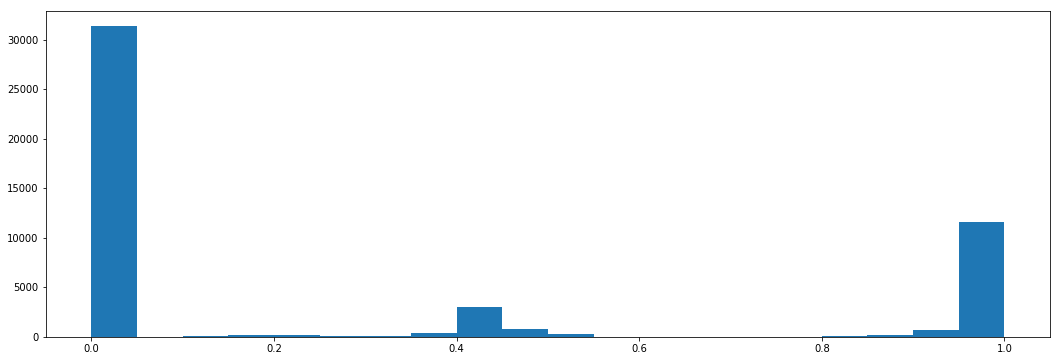

In [13]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [14]:
gen_model.weights.lf_accuracy()

array([ 0.8347283 ,  0.83886696,  0.83882948,  0.83891417,  0.83883349,
        0.83909422,  0.83896739,  0.83887068,  0.83522491,  0.83885966,
        0.83892803,  0.84206445,  0.84198309,  0.84184897,  0.85835531,
        0.85191113,  0.82655025,  0.83369978,  0.83441775,  0.83881191,
        0.83475477,  0.83892882,  0.83559695,  0.83607171,  0.83687768,
        0.83913858,  0.84270226,  0.83925904,  0.83128779,  0.83891033,
        0.83590365,  0.83568404,  0.83670992,  0.84478527,  0.83292969,
        0.84671374,  0.83142875,  0.83910303,  0.8388553 ,  0.85522018,
        0.83898223,  0.83570534,  0.83897513,  0.8393548 ,  0.8393876 ,
        0.84183427,  0.83542178,  0.83562259,  0.85834749,  0.83878895,
        0.83885412,  0.83424867,  0.83601076,  0.83893406,  0.83473607,
        0.83891833,  0.8389421 ,  0.83427072,  0.83388436,  0.8394214 ,
        0.83668427,  0.83931506,  0.83913302,  0.84815494])

In [15]:
from snorkel.annotations import save_marginals
save_marginals(session, L_train, train_marginals)

Saved 49042 training marginals


In [16]:
from snorkel.annotations import load_marginals
train_marginals = load_marginals(session, split=3)

### Using the Model to Iterate on Labeling Functions
Now that we have learned the generative model, we can stop here and use this to potentially debug and/or improve our labeling function set. First, we apply the LFs to our development set:

In [17]:
L_dev = labeler.apply_existing(split=4, parallelism=multiprocessing.cpu_count())

Clearing existing...
Running UDF...


In [18]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold_complex', split=4)

In [19]:
tp, fp, tn, fn = gen_model.score(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.728
Neg. class accuracy: 0.712
Precision            0.488
Recall               0.728
F1                   0.584
----------------------------------------
TP: 523 | FP: 549 | TN: 1354 | FN: 195



In [35]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    sv = SentenceNgramViewer(tp, session, height=400)
else:
    sv = None

<IPython.core.display.Javascript object>

In [36]:
sv

At this point, we should be getting an F1 score of around 0.6 to 0.7 on the development set, which is pretty good! However, we should be very careful in interpreting this. Since we developed our labeling functions using this development set as a guide, and our generative model is composed of these labeling functions, we expect it to score very well here!
In fact, it is probably somewhat overfit to this set. However this is fine, since in the next tutorial, we'll train a more powerful end extraction model which will generalize beyond the development set, and which we will evaluate on a blind test set (i.e. one we never looked at during development).

## Doing Some Error Analysis

In [ ]:
At this point, we might want to look at some examples in one of the error buckets. For example, one of the false negatives that we did not correctly label as true mentions. To do this, we can again just use the Viewer:

In [22]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    sv = SentenceNgramViewer(fp, session, height=400)
else:
    sv = None

<IPython.core.display.Javascript object>

In [45]:
sv

In [ ]:
from snorkel.lf_helpers import (
    get_left_tokens,
    get_between_tokens,
    get_right_tokens,
    contains_token,
    get_doc_candidate_spans,
    get_sent_candidate_spans,
    get_text_between,
    get_text_splits,
    get_tagged_text,
    is_inverted,
    get_tagged_text,
)
c = sv.get_selected() if sv else list(fp.union(fn))[0]
print(c)
print("\n")

c.labels
fp

## Automatically Creating Features

In [20]:
from snorkel.annotations import FeatureAnnotator
import multiprocessing
featurizer = FeatureAnnotator()

In [ ]:
%time F_train = featurizer.apply(split=3, parallelism=multiprocessing.cpu_count())
F_train

Clearing existing...
Running UDF...



Next, we apply the feature set we just got from the training set to the dev and test sets by using apply_existing:

In [ ]:
%%time
F_dev  = featurizer.apply_existing(split=4, parallelism=multiprocessing.cpu_count())
F_test = featurizer.apply_existing(split=5, parallelism=multiprocessing.cpu_count())

Clearing existing...
Running UDF...
Clearing existing...
Running UDF...
CPU times: user 2min 22s, sys: 6.58 s, total: 2min 29s
Wall time: 6min


In [27]:
F_train = featurizer.load_matrix(session, split=3)
F_dev   = featurizer.load_matrix(session, split=4)
F_test  = featurizer.load_matrix(session, split=5)

## Training the Discriminative Model

We use the training marginals to train a discriminative model that classifies each Candidate as a true or false mention. We'll use a random hyperparameter search, evaluated on the development set labels, to find the best hyperparameters for our model. To run a hyperparameter search, we need labels for a development set. If they aren't already available, we can manually create labels using the Viewer.

In [28]:
from snorkel.learning import SparseLogisticRegression
disc_model = SparseLogisticRegression()


Now we set up and run the hyperparameter search, training our model with different hyperparamters and picking the best model configuration to keep. We'll set the random seed to maintain reproducibility.
Note that we are fitting our model's parameters to the training set generated by our labeling functions, while we are picking hyperparamters with respect to score over the development set labels which we created by hand.

In [29]:
from snorkel.learning.utils import MentionScorer
from snorkel.learning import RandomSearch, ListParameter, RangeParameter

# Searching over learning rate
rate_param = RangeParameter('lr', 1e-6, 1e-2, step=1, log_base=10)
l1_param  = RangeParameter('l1_penalty', 1e-6, 1e-2, step=1, log_base=10)
l2_param  = RangeParameter('l2_penalty', 1e-6, 1e-2, step=1, log_base=10)

searcher = RandomSearch(session, disc_model, F_train, train_marginals, [rate_param, l1_param, l2_param], n=20)

Initialized RandomSearch search of size 20. Search space size = 125.


Next, we'll load in our dev set labels. We will pick the optimal result from the hyperparameter search by testing against these labels:

In [30]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold_complex', split=1)

Finally, we run the hyperparameter search / train the end extraction model:

In [32]:
np.random.seed(1701)
searcher.fit(F_dev, L_gold_dev, n_epochs=50, rebalance=0.5, print_freq=25)

[1] Testing lr = 1.00e-02, l1_penalty = 1.00e-03, l2_penalty = 1.00e-04
[SparseLR] lr=0.01 l1=0.001 l2=0.0001
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=25364  #epochs=50  batch size=100
[SparseLR] Epoch 0 (23.55s)	Avg. loss=0.947219	NNZ=335440
[SparseLR] Epoch 25 (612.21s)	Avg. loss=0.675827	NNZ=335440
[SparseLR] Epoch 49 (1177.96s)	Avg. loss=0.666087	NNZ=335440
[SparseLR] Training done (1177.96s)


KeyError: 512842


Note that to train a model without tuning any hyperparameters (at your own risk) just use the train method of the discriminative model. For instance, to train with 20 epochs and a learning rate of 0.001, you could run:
disc_model.train(F_train, train_marginals, n_epochs=20, lr=0.001)
We can analyze the learned model by examining the weights. For example, we can print out the features with the highest weights.

In [ ]:
w, _ = disc_model.get_weights()
largest_idxs = reversed(np.argsort(np.abs(w))[-5:])
for i in largest_idxs:
    print 'Feature: {0: <70}Weight: {1:.6f}'.format(F_train.get_key(session, i).name, w[i])


In this last section of the tutorial, we'll get the score we've been after: the performance of the extraction model on the blind test set (split 2). First, we load the test set labels and gold candidates we made in Part III.

In [ ]:
from snorkel.annotations import load_gold_labels
L_gold_test = load_gold_labels(session, annotator_name='gold_complex', split=5)

Now, we score using the discriminative model:

In [ ]:
_, _, _, _ = disc_model.score(session, F_test, L_gold_test)


Note that if this is the final test set that you will be reporting final numbers on, to avoid biasing results you should not inspect results. However you can run the model on your development set and, as we did in the previous part with the generative labeling function model, inspect examples to do error analysis.

# Thomas's Code
## `DDLiteModel` objects and feature generation
We'll then create a `DDLiteModel` object for our extracted gene candidates. This lets us iterate with our model and labeling functions. Since `Entities` object defines a feature generation method, features are automatically created when we initialize a `DDLiteModel` object. These are generic features from the NLP markup and dependency tree in the neighborhood of the mention. Alternatively, you can define a custom feature set as a NumPy array or a Scipy sparse matrix. Here, we pickle our feature matrix so we don't have to recompute it in the future.

In [ ]:
feats = None

pkl_f = 'gene_tag_example/gene_tag_feats_v1.pkl'
try:
    with open(pkl_f, 'rb') as f:
        feats = cPickle.load(f)
except:
    %time E.extract_features()
    with open(pkl_f, 'w+') as f:
        cPickle.dump(E.feats, f)

DDL = DDLiteModel(E, feats)
print "Extracted {} features for each of {} mentions".format(DDL.num_feats(), DDL.num_candidates())

We need a blind, gold standard ground truth set to evaluate our predictions. We can add these by using the uids for the candidates we want, and align these with a value of 1 for positive or a value of -1 for negative. We'll load in a set now using `DDL.update_gt()` and set it as the holdout. We'll assign half of the holdout to a validation set for parameter tuning, and the other half to a test set.

In [ ]:
with open('gene_tag_example/gt/uids.pkl', 'rb') as f:
    uids = cPickle.load(f)
with open('gene_tag_example/gt/gt.pkl', 'rb') as f:
    gt = cPickle.load(f)
    
DDL.update_gt(gt[:50], uids=uids[:50])
DDL.set_holdout(validation_frac=0.5)

## Building a ground truth set with MindTagger
In order to evaluate our labeling functions and learning results, we'll create a small set of ground truth labels for some candidates using [Mindtagger](http://deepdive.stanford.edu/labeling). This will highlight each candidate in the sentence in which it appears. We set the response to yes if it is a mention of gene, and no otherwise. If you aren't sure, you can abstain from labeling. In a real application, we would likely want to tag more than 20 candidates.

In [ ]:
DDL.open_mindtagger(num_sample=100, width='100%', height=1200)

Now, we'll retrieve the tags and add them to our `DDLiteModel`. We can also use a previously defined Mindtagger label set, similar to how we added our gold labels (this time, we'll use indexes instead of uids). These labels are used for evaluating our labeling functions against the *development set*.

In [ ]:
DDL.add_mindtagger_tags()

In [ ]:
DDL.update_gt(gt[50:], uids=uids[50:])

## Writing labeling functions
We'll use data programming to learn a logistic regression model which will predict the probability of a candidate entity being a true gene mention. Since our training data is not manually labeled, we'll generate many (potentially noisy) labels as a surrogate for precise, manual labels. Feature extraction and model learning are very simple in ddlite. Writing labeling functions is where the real artistry comes in. One of ddlite's goals is to enable rapid prototyping, debugging, and experimenting with labeling functions. These can be used either to create a simple standalone app, or to plug into DeepDive. Labeling functions, or LFs, are functions that take an `Candidate` object. They must return 1 (for a positive label), 0 (for abstaining), or -1 (for a negative example). For now, we'll write a few simple LFs to get started:

* The first, second, and third LFs return a positive label if the lemma "gene", "mutant", or "express" appear in a window around the mention, respectively
* The third LF returns a positive label if the dependency parent of any of the words in the mention is "mutation", and abstains otherwise
* The fourth, fifth, and sixth LF return a negative label if the mention candidate contains "DNA", "RNA", or "SNP" respectively (these are common uppercase nouns which are not genes) 

In [ ]:
def LF_gene(m):
    return 1 if ('gene' in m.post_window('lemmas')) or ('gene' in m.pre_window('lemmas')) else 0
def LF_gene_dp(m):
    return 1 if 'gene' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_genotype_dp(m):
    return 1 if 'genotype' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_mutant(m):
    return 1 if ('mutant' in m.post_window('lemmas')) or ('mutant' in m.pre_window('lemmas')) else 0
def LF_variant(m):
    return 1 if ('variant' in m.post_window('lemmas')) or ('variant' in m.pre_window('lemmas')) else 0
def LF_express(m):
    return 1 if ('express' in m.post_window('lemmas')) or ('express' in m.pre_window('lemmas')) else 0
def LF_mutation(m):
    return 1 if 'mutation' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_JJ(m):
    return 1 if 'JJ' in m.post_window('poses') else 0
def LF_IN(m):
    return 1 if 'IN' in m.pre_window('poses', 1) else 0

def LF_dna(m):
    return -1 if 'DNA' in m.mention('words') else 0
def LF_rna(m):
    return -1 if 'RNA' in m.mention('words') else 0
def LF_snp(m):
    return -1 if 'SNP' in m.mention('words') else 0
def LF_protein(m):
    return -1 if 'protein' in m.pre_window('lemmas') else 0
def LF_LRB(m):
    return -1 if '-LRB-' in m.post_window('poses', 1) else 0
def LF_RRB(m):
    return -1 if '-RRB-' in m.post_window('poses', 1) else 0
def LF_dev_dp(m):
    return -1 if 'development' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_protein_dp(m):
    return -1 if 'protein' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_network_dp(m):
    return -1 if 'network' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_JJ_dp(m):
    return -1 if 'JJ' in [m.poses[m.dep_parents[i] - 1] for i in m.idxs] else 0
def LF_NNP(m):
    return -1 if 'NNP' in m.mention('poses') else 0

Our intuition is that the few simple LFs given above won't yield a good model. We'll see this more concretely when we evaluate the labeling functions. For now, let's leave them as is. After writing the LFs, we simply collect them and apply them to mentions. If we define more LFs later, we can apply them incrementally or overwrite all the LFs so far.

In [ ]:
LFs = [LF_JJ, LF_JJ_dp, LF_NNP, LF_RRB, LF_dev_dp, LF_dna, LF_express, LF_gene, LF_gene_dp,
       LF_genotype_dp, LF_mutant, LF_mutation, LF_network_dp, LF_protein, LF_protein_dp,
       LF_rna, LF_snp, LF_variant, LF_IN, LF_LRB]
DDL.apply_lfs(LFs, clear=False)

We'll use ddlite's LF assessment utilities to debug and analyze our LFs before running inference. First, we'll generate summary plots which show the following:

* Do the LFs cover the data well or do we have many candidates for which all of the LFs abstained?
* Is there overlap between the LFs? Do many return positive or negative labels for the same candidate?
* Do the LFs conflict with each other? Do candidates tend to have many of one type of label, or a mix?

In [ ]:
DDL.print_lf_stats()

In [ ]:
DDL.plot_lf_stats()

As we may expect, the few LFs do not cover the data very well. We can switch to an LF view of these measures and show tables for the LFs with the most conflict, lowest coverage, and lowest empirical accuracy as compared to the development set labels.

In [ ]:
DDL.top_conflict_lfs(n=3)

In [ ]:
DDL.lowest_coverage_lfs(n=3)

In [ ]:
DDL.lowest_empirical_accuracy_lfs(n=10)

In [ ]:
DDL.lf_summary_table()

Since our development set is small, we can't evaluate LF performance particularly well. If we observe LFs with very low accuracy, poor generalization, and a sufficiently large sample size, this could be an indication that the LF is buggy.

## Learning
To learn weights for the features and LFs, we use a simple, regularized logistic regression model. Again, the results won't be meaningful without more LFs. We'll tell ddlite to log the results and print out a summary table

In [ ]:
matplotlib.rcParams['figure.figsize'] = (12,4)
mu_seq = np.ravel([1e-9, 1e-5, 1e-3, 1e-1])
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'sample': False, 'n_iter': 3000, 'alpha': 0.5, 'mu': mu_seq, 'bias': False, 'verbose': True}
%time DDL.train_model(method='lr', lf_opts=lf_opts, model_opts=model_opts)

We can use [DeepDive-style calibration plots](http://deepdive.stanford.edu/calibration) to evaluate the quality of our predictions.

In [ ]:
DDL.plot_calibration()

Since we used pipeline learning, we can also see the gain in accuracy we got from using features and not just LFs as a collection of rules.

In [ ]:
idxs, gt = DDL.get_labeled_ground_truth(subset=DDL.holdout())
acc_feats = np.mean(DDL.get_predicted(subset=DDL.holdout()) == gt)
acc_lfs = np.mean(DDL.get_lf_predicted(subset=DDL.holdout()) == gt)
print "LF accuracy: {:.3f}\nFull model accuracy: {:.3f}".format(acc_lfs, acc_feats)

## Iterating with labeling functions
After analyzing our LFs and obtaining model results, we can revise our LF set. We can see all of the results thus far, and reopen MindTagger to see some mentions that aren't currently covered by LFs.

In [ ]:
DDL.show_log()

In [ ]:
DDL.open_mindtagger(width='100%', height=1200, abstain=True)

In order to use LSTM to learn weights, we just just call the following functions.

In [ ]:
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'n_iter': 300, 'verbose': True, 'contain_mention': True, 'word_window_length': 0, 'ignore_case': False}
%time DDL.train_model(method='lstm', lf_opts=lf_opts, model_opts=model_opts)

In [ ]:
idxs, gt = DDL.get_labeled_ground_truth(subset=DDL.holdout())
acc_feats = np.mean(DDL.get_predicted(subset=DDL.holdout()) == gt)
print "Full model accuracy: {:.3f}".format(acc_feats)